# Analysis of cycling microglia from experiment 1

This notebook generates major results in Figures S4 for the cycling microglia from Experiment 1 (without transcription and translation inhibitors).

# Preparation

This list includes the necessary packages to run the notebook, along with some that may not be required here but are commonly used for exploring adata.

In [61]:
import os
import re
import time
import glob
import csv
import seqc
import h5py
import tables
import seqc.filter
import warnings
import itertools
import harmony
import palantir as pl
import scvelo as scv
import cellrank as cr
import collections
import statsmodels
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import doubletdetection
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp
import scanpy as sc
import seaborn as sns
import scrublet as scr
import anndata as ad
import networkx as nx
import logging
import scipy.cluster.hierarchy as shc
import scanpy.external as sce
import logging

from pathlib import Path
from typing import Dict
from scipy import sparse
from scipy import io
from scipy.sparse.csgraph import connected_components
from sklearn.preprocessing import normalize
from itertools import compress
from kneed import KneeLocator
from copy import deepcopy
from seqc import plot
from seqc.plot import FigureGrid
from collections import OrderedDict
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from seqc.sparse_frame import SparseFrame
from scipy.io import mmwrite
from adjustText import adjust_text

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [2]:
# Define and customize plot attributes
%matplotlib inline
sc.set_figure_params(dpi=80) 

sns.set_style("whitegrid")
mpl.rcParams['figure.figsize'] = [4,4]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 150
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['image.cmap'] = 'Spectral_r'
mpl.style.use("ggplot")
mpl.rcdefaults()
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

logging.getLogger('matplotlib').setLevel(logging.ERROR)

# Initialize

In [77]:
# Change directory to the desired path:
DATA_DIR = '/data/massague/gans/projects/Breast_tumor/GitHub/Data/'

# Sub-directory for the data of cycling microglia from experiment 1 
source = 'Cycling_MG_1/'

# Processed adata
for h5_file in Path(DATA_DIR+source).glob('*.h5'):    
    adata = sc.read(h5_file) # Log-transformed, normalized data

## Load MILO results

### Neighborhood indexes and cell counts

In [7]:
# Directory for the Milo results
MILO_DIR = DATA_DIR+source+'Milo/'

# 'None' in the file name indicates that transcription and translation inhibitors are not added:
nhoodIdx = (pd.read_csv(MILO_DIR+'Tr_tl_inhibitors_None_Proliferating microglia_milo.nhoodIndex.csv', index_col=0)-1).T

# Each row in column "1": the index cell per Milo neighborhood
nhoodIdx

,1
X12,11
X14,13
X44,43
X13,12
X28,27
X40,39
X15,14
X25,24
X18,17
X55,54


In [8]:
nhoodCounts = pd.read_csv(MILO_DIR+'Tr_tl_inhibitors_None_Proliferating microglia_milo.nhoodCounts.csv', index_col=0)

# Number of cells from each source per neighborhood
nhoodCounts 

,HER2BC_Unlabeled,TNBC_Unlabeled,HER2BC_Labeled,TNBC_Labeled
1,3,0,128,50
2,6,0,78,56
3,3,0,55,47
4,1,0,95,26
5,0,0,34,14
6,0,0,61,16
7,0,0,68,5
8,0,0,66,8
9,2,1,31,23
10,2,1,65,28


In [9]:
# Update row names in the above Milo results to match the corresponding obs_names of adata
nhoodIdx.index = adata.obs_names[nhoodIdx][:,0]
nhoodCounts.index = nhoodIdx.index

### Generalized linear model (GLM) fit results

In [11]:
fit = pd.read_csv(MILO_DIR+'Tr_tl_inhibitors_None_Proliferating microglia_milo.nhoodCountsFit.csv', index_col=0)
fit.index = nhoodIdx.index
fit

,(Intercept),groupHER2BC_Labeled,groupTNBC_Labeled
Labeled_stromal_cells_165849555162862-1-0,-0.395870,3.264316,2.451751
Labeled_stromal_cells_200967517071091-1-0,0.277382,2.096736,1.891453
Labeled_stromal_cells_155828740615389-1-0,-0.388212,2.414017,2.382441
Labeled_stromal_cells_196576871372524-1-0,-1.409851,3.980682,2.815025
Labeled_stromal_cells_126820562712310-1-0,-3.600588,5.147643,4.392450
Labeled_stromal_cells_133906824817523-1-0,-3.600588,5.729580,4.524433
Labeled_stromal_cells_134385027929846-1-0,-3.600588,5.837879,3.384853
Labeled_stromal_cells_196166670735709-1-0,-3.600588,5.808114,3.842069
Labeled_stromal_cells_240152489876211-1-0,-0.388164,1.843407,1.671610
Labeled_stromal_cells_231753037077724-1-0,-0.388164,2.580469,1.866968


In [12]:
# Add UMAP embedding results to assist downstream visualization
fit.loc[:,['UMAP_1','UMAP_2']] = adata[fit.index].obsm['X_umap']
fit

,(Intercept),groupHER2BC_Labeled,groupTNBC_Labeled,UMAP_1,UMAP_2
Labeled_stromal_cells_165849555162862-1-0,-0.395870,3.264316,2.451751,2.800552,-0.619816
Labeled_stromal_cells_200967517071091-1-0,0.277382,2.096736,1.891453,3.259963,2.479357
Labeled_stromal_cells_155828740615389-1-0,-0.388212,2.414017,2.382441,2.765963,2.516145
Labeled_stromal_cells_196576871372524-1-0,-1.409851,3.980682,2.815025,3.147687,-0.004596
Labeled_stromal_cells_126820562712310-1-0,-3.600588,5.147643,4.392450,1.291552,1.150064
Labeled_stromal_cells_133906824817523-1-0,-3.600588,5.729580,4.524433,0.062909,1.082706
Labeled_stromal_cells_134385027929846-1-0,-3.600588,5.837879,3.384853,2.792466,-1.855683
Labeled_stromal_cells_196166670735709-1-0,-3.600588,5.808114,3.842069,0.089064,-0.283648
Labeled_stromal_cells_240152489876211-1-0,-0.388164,1.843407,1.671610,6.398475,-0.234244
Labeled_stromal_cells_231753037077724-1-0,-0.388164,2.580469,1.866968,5.168041,1.244102


In [13]:
# Note the fit results have also been added to the adata provided, using: 
adata.obs['GLM_coeff_HER2BC_Labeled'] = np.nan
adata.obs['GLM_coeff_TNBC_Labeled'] = np.nan

adata.obs['GLM_coeff_HER2BC_Labeled'][fit.index] = fit.loc[:,'groupHER2BC_Labeled']
adata.obs['GLM_coeff_TNBC_Labeled'][fit.index] = fit.loc[:,'groupTNBC_Labeled']

### Differential abundance results

In [15]:
# da: "differential abundance", saved as a dictionary, with the keys set to the groups compared
da = {}

In [19]:
for k in ['TNvsHER2', 'TNvsCtrl', 'HER2vsCtrl', 'LabeledvsCtrl']:
    
    da[k] = pd.read_csv(MILO_DIR+'Tr_tl_inhibitors_None_Proliferating microglia_milo.da_'+k+'.csv', index_col=0)

    # Note "-1" comes from the fact that index starts from 1 in R and from 0 in Python
    # To match the Milo results obtained in R to Python, need to -1
    da[k].loc[:,'Nhood'] = da[k].index-1

    da[k].index = nhoodIdx.index
    da[k].loc[:,'neg_log10(SpatialFDR)'] = -np.log10(da[k].loc[:,'SpatialFDR'])

    # Total No. of cells in the neighborhood
    da[k].loc[:,'nhood_size'] = nhoodCounts.sum(axis=1).to_numpy()
    
    # Update results to adata
    adata.obs[k+'_neg_log10(SpatialFDR)'] = np.nan
    adata.obs[k+'_neg_log10(SpatialFDR)'][da[k].index] = da[k].loc[:,'neg_log10(SpatialFDR)']
    fit.loc[:,k+'_neg_log10(SpatialFDR)'] = da[k].loc[fit.index,'neg_log10(SpatialFDR)']
    
    if k != 'LabeledvsCtrl':
        adata.obs[k+'_logFC'] = np.nan
        adata.obs[k+'_logFC'][da[k].index] = da[k].loc[:,'logFC']
        fit.loc[:,k+'_logFC'] = da[k].loc[fit.index,'logFC']
        
fit.loc[:,'nhood_size'] = da['TNvsHER2'].loc[fit.index,'nhood_size']
fit

,(Intercept),groupHER2BC_Labeled,groupTNBC_Labeled,UMAP_1,UMAP_2,TNvsHER2_neg_log10(SpatialFDR),TNvsHER2_logFC,TNvsCtrl_neg_log10(SpatialFDR),TNvsCtrl_logFC,HER2vsCtrl_neg_log10(SpatialFDR),HER2vsCtrl_logFC,LabeledvsCtrl_neg_log10(SpatialFDR),nhood_size
Labeled_stromal_cells_165849555162862-1-0,-0.395870,3.264316,2.451751,2.800552,-0.619816,2.488223,-1.172284,6.216074,3.537129,14.580669,4.709413,13.742098,181
Labeled_stromal_cells_200967517071091-1-0,0.277382,2.096736,1.891453,3.259963,2.479357,0.312989,-0.296161,6.088064,2.728790,8.679593,3.024951,8.230701,140
Labeled_stromal_cells_155828740615389-1-0,-0.388212,2.414017,2.382441,2.765963,2.516145,0.058738,-0.045556,7.238550,3.437135,8.603913,3.482691,8.588118,105
Labeled_stromal_cells_196576871372524-1-0,-1.409851,3.980682,2.815025,3.147687,-0.004596,6.106022,-1.681687,4.942522,4.061223,16.531081,5.742910,17.732479,122
Labeled_stromal_cells_126820562712310-1-0,-3.600588,5.147643,4.392450,1.291552,1.150064,1.735152,-1.089513,3.871224,6.336965,8.047775,7.426478,7.339644,48
Labeled_stromal_cells_133906824817523-1-0,-3.600588,5.729580,4.524433,0.062909,1.082706,5.129220,-1.738658,4.282149,6.527378,13.576517,8.266036,14.121696,77
Labeled_stromal_cells_134385027929846-1-0,-3.600588,5.837879,3.384853,2.792466,-1.855683,12.166795,-3.538969,1.698230,4.883310,14.610138,8.422279,20.366268,73
Labeled_stromal_cells_196166670735709-1-0,-3.600588,5.808114,3.842069,0.089064,-0.283648,9.768128,-2.836404,2.456824,5.542934,14.580669,8.379338,18.143799,74
Labeled_stromal_cells_240152489876211-1-0,-0.388164,1.843407,1.671610,6.398475,-0.234244,0.214391,-0.247851,3.100030,2.411623,4.120550,2.659475,3.547911,57
Labeled_stromal_cells_231753037077724-1-0,-0.388164,2.580469,1.866968,5.168041,1.244102,2.723957,-1.029364,3.984143,2.693466,10.437359,3.722830,9.875187,96


### Adjacency matrix of neighbors

In [20]:
# Number of neighbors: i.e., number of cells shared between different neighborhoods (off-diagonal)
# On the diagonal line, number of cells per neighborhood 

nhoodAdj = pd.read_csv(MILO_DIR+'Tr_tl_inhibitors_None_Proliferating microglia_milo.nhoodIndex.adj.csv', index_col=0)
nhoodAdj

,12,14,44,13,28,40,15,25,18,55,22,176,48,33,21
12,181,70,53,87,14,33,49,33,25,56,68,32,65,65,49
14,70,140,89,51,23,21,7,7,17,63,34,48,28,35,58
44,53,89,105,38,24,20,10,7,4,39,33,24,19,35,53
13,87,51,38,122,24,11,30,14,6,40,43,12,22,40,48
28,14,23,24,24,48,16,2,12,0,5,22,2,0,20,23
40,33,21,20,11,16,77,21,55,4,5,33,5,23,49,9
15,49,7,10,30,2,21,73,34,15,22,21,8,39,23,5
25,33,7,7,14,12,55,34,74,2,2,33,0,21,40,2
18,25,17,4,6,0,4,15,2,57,32,1,40,37,3,0
55,56,63,39,40,5,5,22,2,32,96,17,45,43,13,22


In [21]:
# Update row and column names to obs_names of the index cells of the neighborhoods 
nhoodAdj.index = nhoodIdx.index
nhoodAdj.columns = nhoodIdx.index
nhoodAdj

,Labeled_stromal_cells_165849555162862-1-0,Labeled_stromal_cells_200967517071091-1-0,Labeled_stromal_cells_155828740615389-1-0,Labeled_stromal_cells_196576871372524-1-0,Labeled_stromal_cells_126820562712310-1-0,Labeled_stromal_cells_133906824817523-1-0,Labeled_stromal_cells_134385027929846-1-0,Labeled_stromal_cells_196166670735709-1-0,Labeled_stromal_cells_240152489876211-1-0,Labeled_stromal_cells_231753037077724-1-0,Labeled_stromal_cells_199937951226091-1-0,Labeled_stromal_cells_197074416749939-1-0,Labeled_stromal_cells_227499932794094-1-0,Labeled_stromal_cells_200418673518901-1-0,Labeled_stromal_cells_157561657145763-1-0
Labeled_stromal_cells_165849555162862-1-0,181,70,53,87,14,33,49,33,25,56,68,32,65,65,49
Labeled_stromal_cells_200967517071091-1-0,70,140,89,51,23,21,7,7,17,63,34,48,28,35,58
Labeled_stromal_cells_155828740615389-1-0,53,89,105,38,24,20,10,7,4,39,33,24,19,35,53
Labeled_stromal_cells_196576871372524-1-0,87,51,38,122,24,11,30,14,6,40,43,12,22,40,48
Labeled_stromal_cells_126820562712310-1-0,14,23,24,24,48,16,2,12,0,5,22,2,0,20,23
Labeled_stromal_cells_133906824817523-1-0,33,21,20,11,16,77,21,55,4,5,33,5,23,49,9
Labeled_stromal_cells_134385027929846-1-0,49,7,10,30,2,21,73,34,15,22,21,8,39,23,5
Labeled_stromal_cells_196166670735709-1-0,33,7,7,14,12,55,34,74,2,2,33,0,21,40,2
Labeled_stromal_cells_240152489876211-1-0,25,17,4,6,0,4,15,2,57,32,1,40,37,3,0
Labeled_stromal_cells_231753037077724-1-0,56,63,39,40,5,5,22,2,32,96,17,45,43,13,22


# Analysis & Visualization

## Examine the differential sample distribution 

Since many visualization and analysis steps rely on a random number seed, each run may produce slight variations. For consistency in this illustration, we load and use the data as processed in the manuscript.

### HER2BC- vs. TNBC-labeled

Due to the limited number of unlabeled cells in non-cycling microglia, we compare HER2BC-labeled microglia to TNBC-labeled cells rather than to unlabeled cells here. Please refer to the Methods section of the paper for a detailed description of the analysis.

In [24]:
fit.loc[:,'HER2vsTN_logFC'] = - fit.loc[:,'TNvsHER2_logFC']
fit.loc[:,'HER2vsTN_neg_log10(SpatialFDR)'] = fit.loc[:,'TNvsHER2_neg_log10(SpatialFDR)']

<b> HER2BC-associated cycling microglia </b>

In [25]:
FDRthre = 1
k = 'TNvsHER2'

incl = (da[k].loc[:,'neg_log10(SpatialFDR)'] >= FDRthre) & \
       (da[k].loc[:,'logFC']<0)
da_sig_idx = da[k].index[incl] 
# Index cells of the neighborhoods w/ significant differential abundance in HER2BC-labeled in ref. to TNBC-labeled microglia 

Create the 'nhood_class' obs. to save the classification of neighborhoods.

In [74]:
adata.obs['nhood_class'] = 'TNBC_cycling' # Default: associated w/ TNBC-labeled cycling microliga
adata.obs['nhood_class'][da_sig_idx] = 'HER2BC_cycling' # da_sig_idx: associated w/ HER2BC-labeled cycling microliga

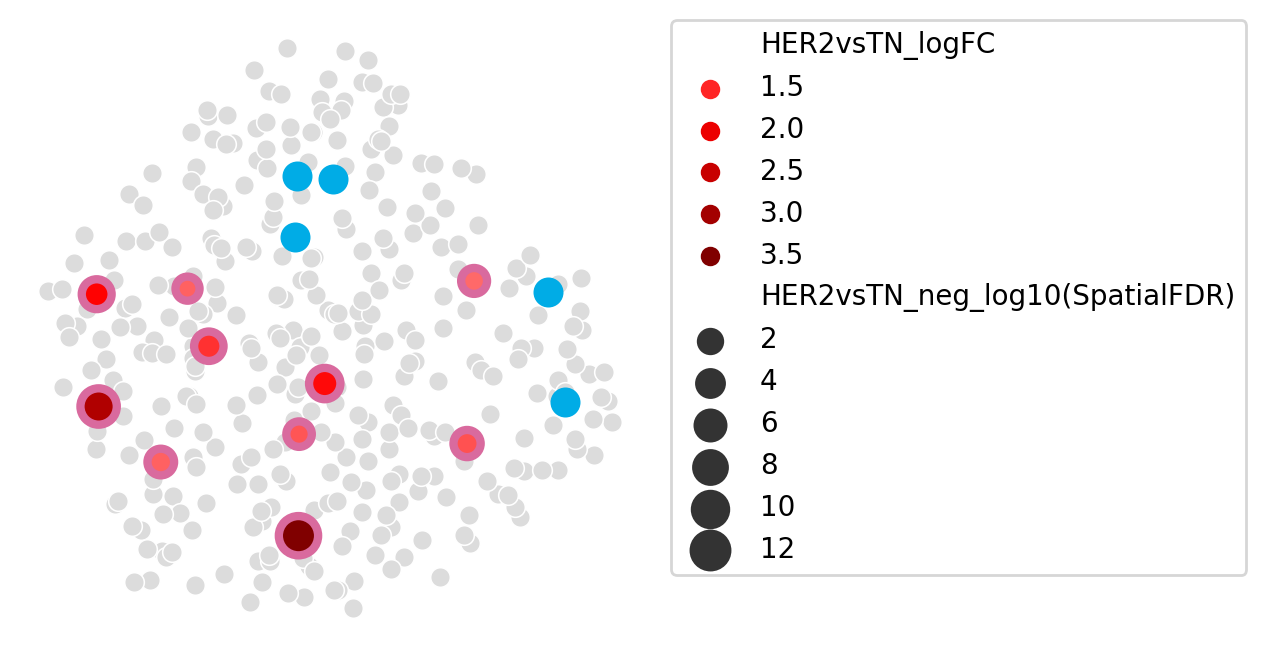

In [33]:
plt.figure(figsize=[4,4])
k = 'HER2vsTN'

# Show all cells
umap = pd.DataFrame(adata.obsm['X_umap'],
                    columns = ["UMAP_1","UMAP_2"])

# Plot all dots
ax = sns.scatterplot(data=umap, x="UMAP_1", y="UMAP_2", 
                     alpha=1, color='gainsboro', s=50) 

# Highlight the index cells of "null" neighborhoods (i.e., not differentially enriched in 
# HER2BC-labeled cells compared to TNBC-labeled cells) as blue dots
ax = sns.scatterplot(data=fit.loc[-incl,:], x="UMAP_1", y="UMAP_2", 
                     alpha=1, color='#00ace6', edgecolor = '#00ace6', s=100) 

sns.scatterplot(data=fit.loc[incl,:],
                x="UMAP_1", y="UMAP_2", 
                size=k+'_neg_log10(SpatialFDR)', 
                hue=k+'_logFC', 
                palette=mpl.cm.seismic,
                hue_norm=(-3.5,3.5),
                sizes=(150/2,400/2),
                edgecolor = '#d96a9e',
                linewidth=3)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_axis_off()

## Examine homeostasis-to-DAM transition together w/ non-cycling microglia 

In [37]:
# Signatures of interest
features = ['nhood_Amit_homeostatic_SCANPY_score',
            'nhood_TGFb_in_vivo_UP_SCANPY_score',
            'nhood_Disease-associated_MG_SCANPY_score',
            'nhood_Amit_stage 1 DAM_UP_SCANPY_score',
            'nhood_Amit_stage 2 DAM_SCANPY_score',
            'nhood_HALLMARK_OXIDATIVE_PHOSPHORYLATION_SCANPY_score',
            'nhood_HALLMARK_GLYCOLYSIS_SCANPY_score',
]

In [56]:
# Neighborhood index cells
MG_idx = adata.obs_names[adata.obs['nhoodIdx']]
values = adata[MG_idx].obs[features].copy()

### Load non-cycling microglia data

In [36]:
# Sub-directory for the data of non-cycling microglia from experiment 1 
source_0 = 'Non_Cycling_MG_1/'

# Processed adata
for h5_file in Path(DATA_DIR+source_0).glob('*.h5'):    
    k = str(h5_file).split('.h5')[0].split('_')[-1]
    adata_0 = sc.read(h5_file) # Log-transformed, normalized data

In [40]:
MG_idx_0 = adata_0.obs_names[adata_0.obs['nhoodIdx']]

adata_0[MG_idx_0].obs[['HER2vsCtrl_logFC','TNvsCtrl_logFC','TNvsHER2_logFC','LabeledvsCtrl_Nhood_merged']]
adata_0[MG_idx_0].obs[features]

,nhood_Amit_homeostatic_SCANPY_score,nhood_TGFb_in_vivo_UP_SCANPY_score,nhood_Disease-associated_MG_SCANPY_score,nhood_Amit_stage 1 DAM_UP_SCANPY_score,nhood_Amit_stage 2 DAM_SCANPY_score,nhood_HALLMARK_OXIDATIVE_PHOSPHORYLATION_SCANPY_score,nhood_HALLMARK_GLYCOLYSIS_SCANPY_score
Unlabeled_stromal_cells_201446646471582-0-0,2.503435,1.082539,0.892013,1.584201,-0.018091,0.260467,0.026680
Unlabeled_stromal_cells_134447990462365-0-0,1.765996,0.846400,1.344316,2.526232,0.797122,0.280397,0.043341
Unlabeled_stromal_cells_121889787169189-0-0,2.114653,0.911452,0.976816,2.534479,0.005771,0.284205,0.027721
Unlabeled_stromal_cells_130118829062580-0-0,1.936965,0.852992,0.889795,1.644503,-0.231316,0.419244,0.061737
Unlabeled_stromal_cells_165260117600692-0-0,1.560620,0.756125,1.318962,2.656867,0.932262,0.313554,0.062816
...,...,...,...,...,...,...,...
Labeled_stromal_cells_126843092684148-1-0,3.173149,1.102977,0.500579,1.816558,-0.392019,0.272739,0.013710
Labeled_stromal_cells_155973292513501-1-0,2.740699,1.017659,0.615433,1.963941,-0.295331,0.207813,0.020635
Labeled_stromal_cells_169014021736235-1-0,2.207977,0.787904,0.776345,2.294679,0.013543,0.188179,0.023765
Labeled_stromal_cells_121731966191349-1-0,3.064475,1.057842,0.518296,1.608503,-0.364696,0.254939,0.017509


### Classify neighborhoods for non-cycling microglia

Print the number of neighborhoods within each category. 

<b> Unlabeled </b>

In [45]:
FDRthre = 1
UN_idx = (adata_0[MG_idx_0].obs['TNvsCtrl_logFC'] < 0) & (adata_0[MG_idx_0].obs['HER2vsCtrl_logFC'] < 0) & \
         (adata_0[MG_idx_0].obs['LabeledvsCtrl_neg_log10(SpatialFDR)'] >= FDRthre)
np.sum(UN_idx == True)

6

<b> TNBC-associated </b>

In [48]:
TNBC_idx = (adata_0[MG_idx_0].obs['TNvsCtrl_logFC'] > 0) & (adata_0[MG_idx_0].obs['TNvsHER2_logFC'] > 0) & \
           (adata_0[MG_idx_0].obs['LabeledvsCtrl_neg_log10(SpatialFDR)'] >= FDRthre)

np.sum(TNBC_idx == True)

124

<b> HER2BC-associated </b>

In [49]:
HER2BC_idx = (adata_0[MG_idx_0].obs['HER2vsCtrl_logFC'] > 0) & (adata_0[MG_idx_0].obs['TNvsHER2_logFC'] < 0) & \
             (adata_0[MG_idx_0].obs['LabeledvsCtrl_neg_log10(SpatialFDR)'] >= FDRthre)

np.sum(HER2BC_idx == True)

192

Copy to obs. 'nhood_class' to save the updated adata.

In [75]:
# Update the results in adata to save
adata_0.obs['nhood_class'] = 'Unclassified'

adata_0.obs['nhood_class'][MG_idx_0[UN_idx]] = 'Unlabeled_nonCycling'
adata_0.obs['nhood_class'][MG_idx_0[TNBC_idx]] = 'TNBC_nonCycling'
adata_0.obs['nhood_class'][MG_idx_0[HER2BC_idx]] = 'HER2BC_nonCycling'

<b> Signature values for non-cycling microglia </b>

In [52]:
values_0 = adata_0[adata_0.obs['nhood_class'] != 'Unclassified'].obs[features].copy()

### Combine & visualize non-cycling and cycling microglia data

In [58]:
values_all = pd.concat([values, values_0])

Visualize the combined, scaled scores using violin plot.

In [62]:
all_sig_scaled = pd.DataFrame(scaler.fit_transform(values_all.to_numpy()),
                              index = values_all.index,
                              columns = values_all.columns)

In [63]:
x = all_sig_scaled.stack().reset_index()
x.columns = ['cells', 'signatures', 'scores']
x = x.set_index(['cells'])
x

,signatures,scores
cells,,
Labeled_stromal_cells_165849555162862-1-0,nhood_Amit_homeostatic_SCANPY_score,0.283213
Labeled_stromal_cells_165849555162862-1-0,nhood_TGFb_in_vivo_UP_SCANPY_score,0.302132
Labeled_stromal_cells_165849555162862-1-0,nhood_Disease-associated_MG_SCANPY_score,0.578736
Labeled_stromal_cells_165849555162862-1-0,nhood_Amit_stage 1 DAM_UP_SCANPY_score,0.542242
Labeled_stromal_cells_165849555162862-1-0,nhood_Amit_stage 2 DAM_SCANPY_score,0.497899
...,...,...
Labeled_stromal_cells_232379719019252-1-0,nhood_Disease-associated_MG_SCANPY_score,0.155820
Labeled_stromal_cells_232379719019252-1-0,nhood_Amit_stage 1 DAM_UP_SCANPY_score,0.521361
Labeled_stromal_cells_232379719019252-1-0,nhood_Amit_stage 2 DAM_SCANPY_score,0.050760


Update the neighborhood classification to x (matrix created for visualization).

In [67]:
x.loc[:,'nhood_class'] = 'TNBC_cycling'

x.loc[MG_idx_0[UN_idx],'nhood_class'] = 'Unlabeled_nonCycling'
x.loc[MG_idx_0[TNBC_idx],'nhood_class'] = 'TNBC_nonCycling'
x.loc[MG_idx_0[HER2BC_idx],'nhood_class'] = 'HER2BC_nonCycling'

x.loc[da_sig_idx,'nhood_class'] = 'HER2BC_cycling'

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'nhood_Amit_homeostatic_SCANPY_score'),
  Text(1, 0, 'nhood_TGFb_in_vivo_UP_SCANPY_score'),
  Text(2, 0, 'nhood_Disease-associated_MG_SCANPY_score'),
  Text(3, 0, 'nhood_Amit_stage 1 DAM_UP_SCANPY_score'),
  Text(4, 0, 'nhood_Amit_stage 2 DAM_SCANPY_score'),
  Text(5, 0, 'nhood_HALLMARK_OXIDATIVE_PHOSPHORYLATION_SCANPY_score'),
  Text(6, 0, 'nhood_HALLMARK_GLYCOLYSIS_SCANPY_score')])

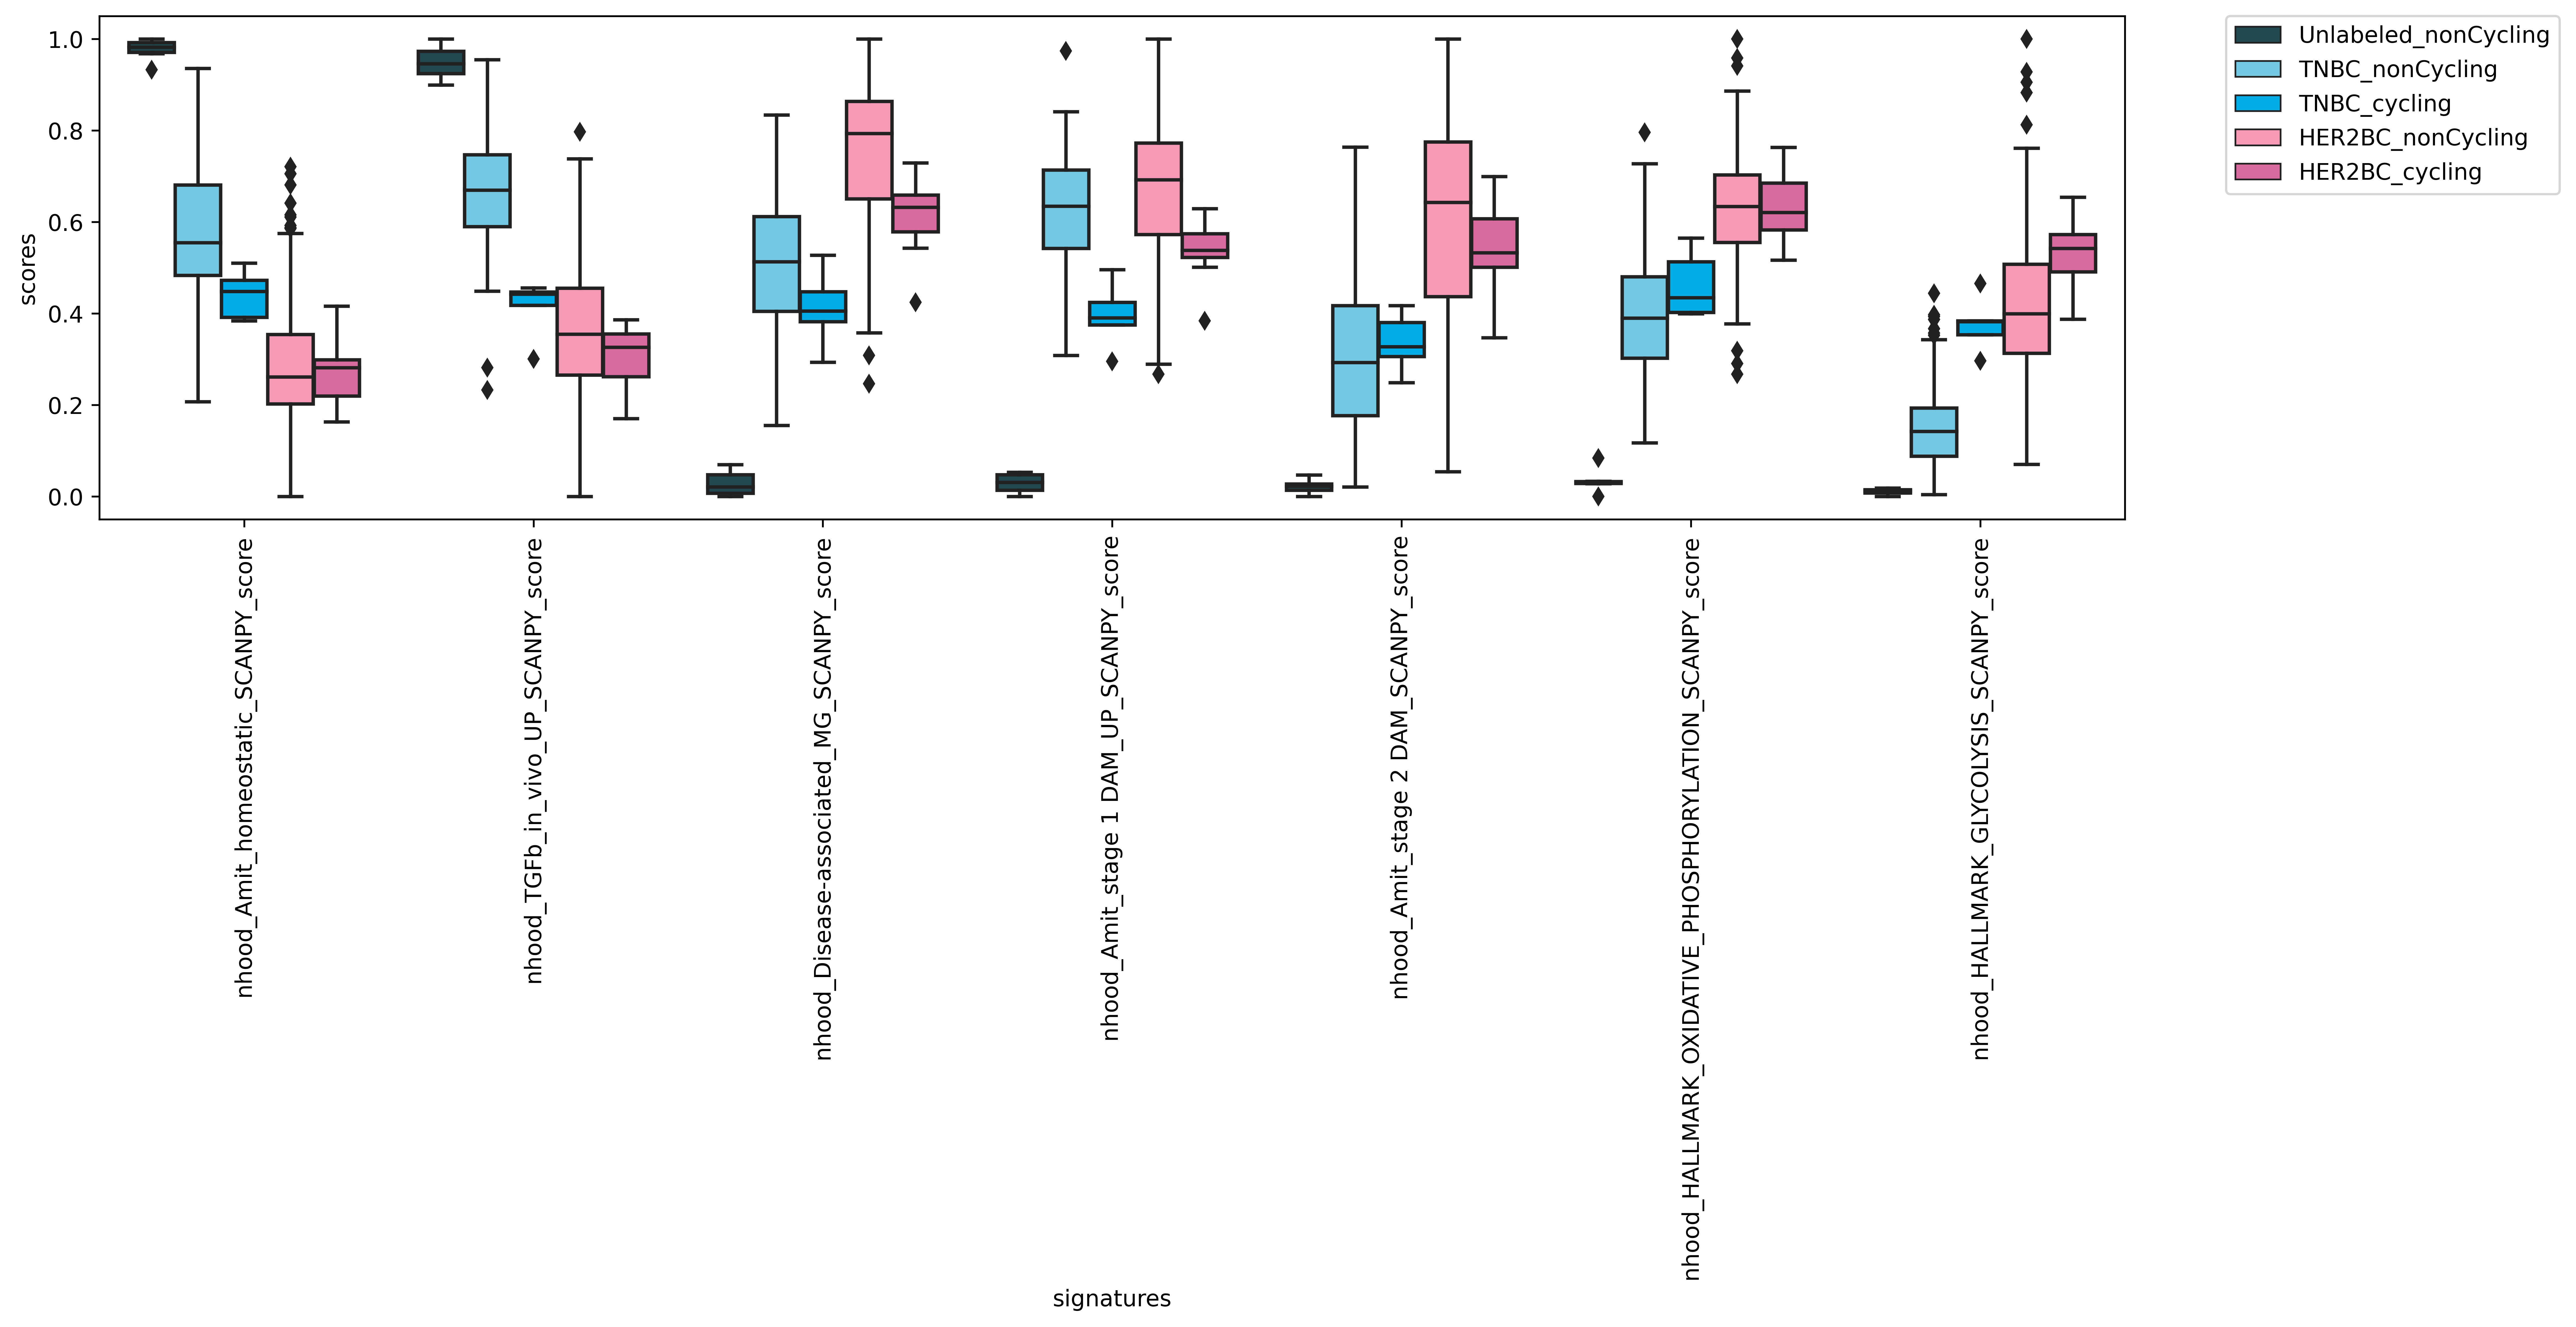

In [71]:
plt.figure(figsize=[16,4])

ax = sns.boxplot(data=x, x="signatures", y="scores", hue="nhood_class",  
                 hue_order=['Unlabeled_nonCycling', 'TNBC_nonCycling', 'TNBC_cycling', 
                            'HER2BC_nonCycling', 'HER2BC_cycling'], saturation=1,
                 palette=['#21474F','#75C8E2','#00ace6','#F599B5','#d96a9e'], 
                ) 
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=90)

# Save results

In [76]:
# Save udpated adata to the original directory
# Cycling microglia
for h5_file in Path(DATA_DIR+source).glob('*.h5'):   
    adata.write(h5_file)

# Non-cycling microglia
for h5_file in Path(DATA_DIR+source_0).glob('*.h5'):   
    adata_0.write(h5_file)    

... storing 'nhood_class' as categorical
... storing 'nhood_class' as categorical
